# Наивный анализ стационарности временных рядов

In [2]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

In [4]:
import glob

# 1. international-airline-passengers

In [143]:
passengers = pd.read_csv(r"D:\TSML\1._Лекция_tsml\international-airline-passengers.csv")

In [64]:
passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [144]:
# для корректного отображения на графике переведем месяца в формат datetime

passengers['Month'] = pd.to_datetime(passengers['Month'], format='%Y-%m')

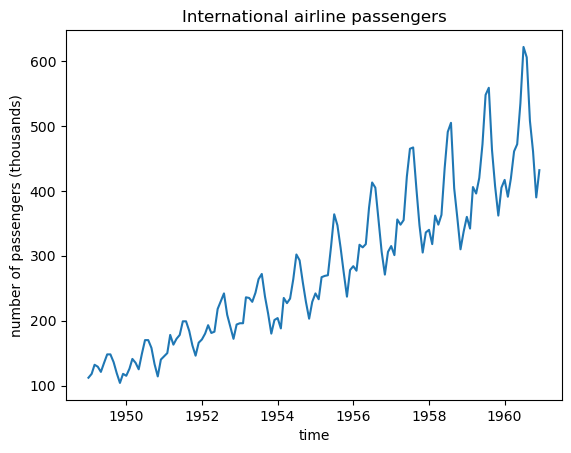

In [45]:
# выведем график

x = passengers.iloc[:, 0]
y = passengers.iloc[:, 1]

plt.plot(x, y)
plt.title('International airline passengers')
plt.xlabel('time')
plt.ylabel('number of passengers (thousands)')
plt.show()

Наблюдаем тренд, напоминающий квадратичную функцию, и сезонность с возрастающей дисперсией

## Логарифмирование
Попробуем нормализовать дисперсию и сделать зависимоть более похожей на линейную

In [46]:
values_ln = boxcox(passengers.iloc[:, 1], 0)

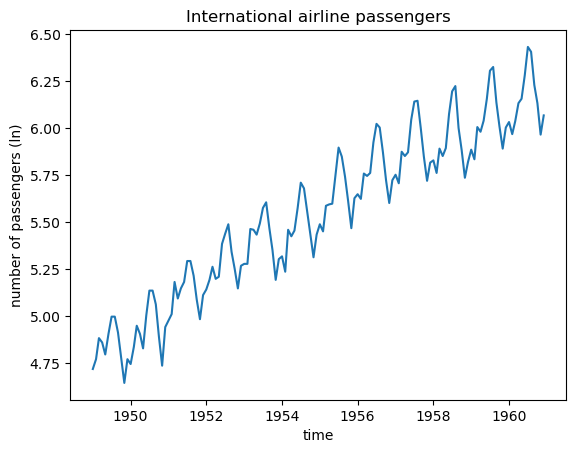

In [47]:
plt.plot(x, values_ln)
plt.title('International airline passengers')
plt.xlabel('time')
plt.ylabel('number of passengers (ln)')
plt.show()

## Дифференцирование
Теперь избавимся от тренда

In [48]:
values_ln_n_diff = np.diff(values_ln, 1)

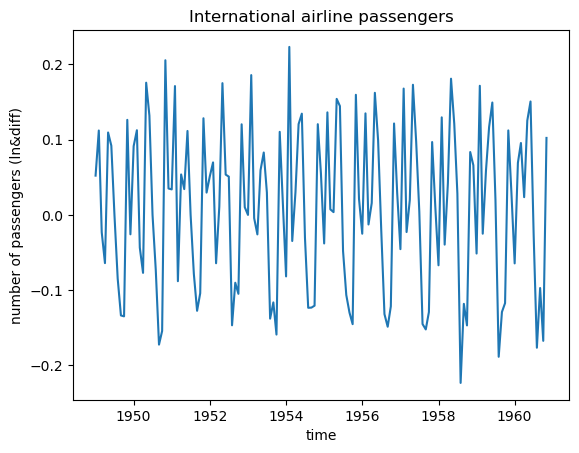

In [49]:
plt.plot(x.drop(index=len(x) - 1), values_ln_n_diff)
plt.title('International airline passengers')
plt.xlabel('time')
plt.ylabel('number of passengers (ln&diff)')
plt.show()

## Проверим на стационарность
Будем использовать готовую функцию из занятия для выведения результата

In [50]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [51]:
test_stationarity(values_ln_n_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


Попробуем повторно применить дифференцирование, чтобы избавиться от сезонности.

In [52]:
values_ln_n_diff2 = np.diff(values_ln_n_diff, 1)

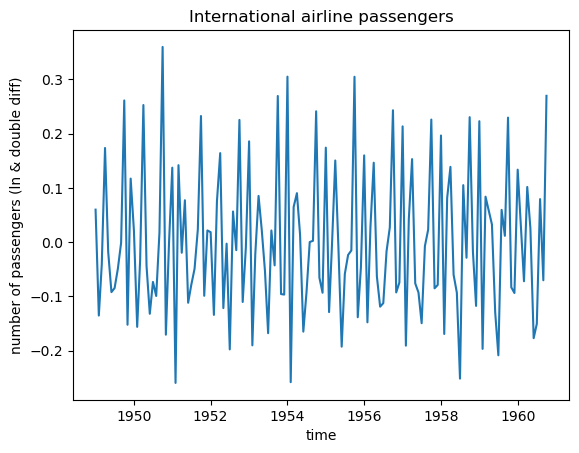

In [53]:
plt.plot(x.drop(index=[len(x) - 1, len(x) - 2]), values_ln_n_diff2)
plt.title('International airline passengers')
plt.xlabel('time')
plt.ylabel('number of passengers (ln & double diff)')
plt.show()

In [54]:
test_stationarity(values_ln_n_diff2)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


# 2. Остальное

In [55]:
# Загрузим оставшиеся датафреймы

path = r'D:\TSML\1._Лекция_tsml\*.csv'
files = glob.glob(path)

In [169]:
my_dict = {}

for file in files:
    name = file.replace('D:\\TSML\\1._Лекция_tsml\\', '').replace('.csv', '').replace('-', '_')
    locals()[name] = pd.read_csv(file)
    my_dict[name] = locals().get(name)
    
locals().get(name).head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [165]:
# Создадим функцию, с помощью которой можно выбирать, 
# какую операцию провести над данными, до тех пор пока ряд не станет стационарным

def make_stationary(my_df):
    def lner(my_df):
        df = my_df.copy()
        df.iloc[:, 1] = boxcox(df.iloc[:, 1], 0)
        return df
    def differ(my_df):
        df = my_df.copy().drop(index=len(my_df) - 1)
        df.iloc[:, 1] = np.diff(my_df.iloc[:, 1], 1)
        return df
    df = my_df.copy()
    ful = adfuller(df.iloc[:, 1], autolag='AIC')[1]
    while ful > 0.05:
        plt.plot(df.iloc[:, 0], df.iloc[:, 1])
        plt.xticks([])
        plt.show()
        todo = input('ln or diff: ')
        if todo == 'ln':
            df = lner(df)
        elif todo == 'diff':
            df = differ(df.drop(index=len(df) - 1))
        ful = adfuller(df.iloc[:, 1], autolag='AIC')[1]
    
    print('p-value: ' + str(ful))

daily_total_female_births_in_cal
p-value: 5.243412990149865e-05

international_airline_passengers


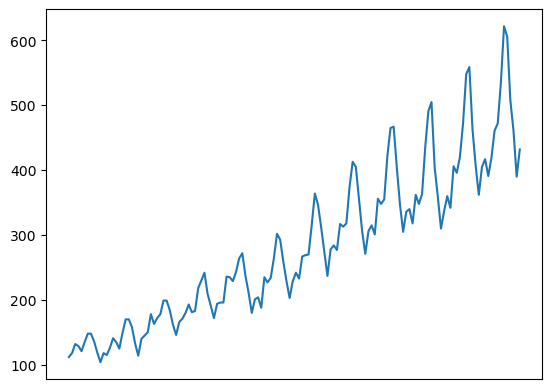

ln or diff: ln


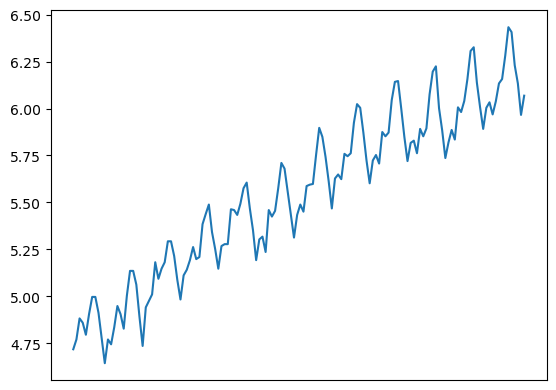

ln or diff: diff


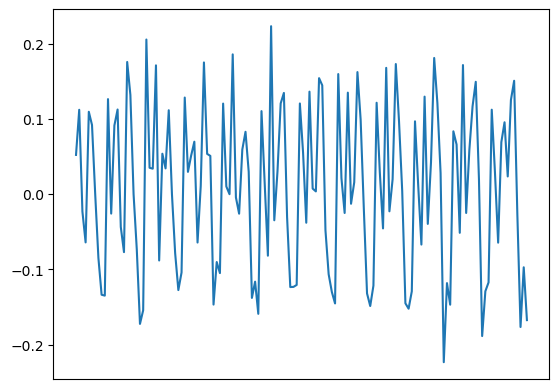

ln or diff: diff
p-value: 7.759724448263779e-13

mean_monthly_air_temperature_deg
p-value: 0.01698903022260905

monthly_boston_armed_robberies_j


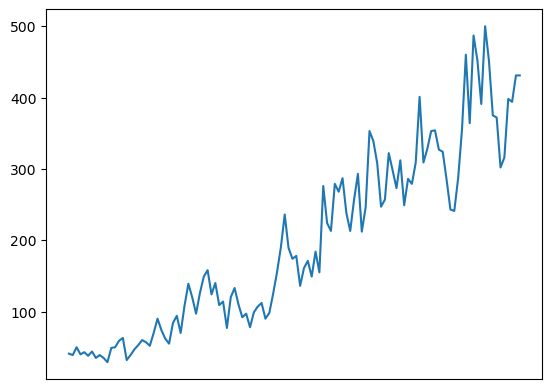

ln or diff: diff
p-value: 3.6035418823299724e-11

monthly_car_sales_in_quebec_1960


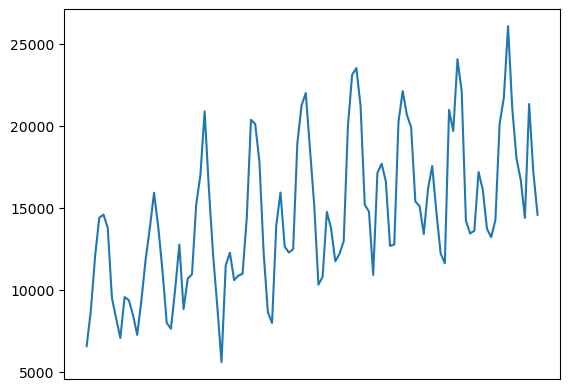

ln or diff: ln


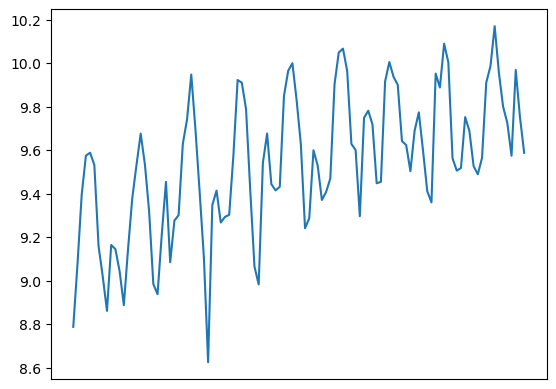

ln or diff: diff
p-value: 0.0008291745126700465

monthly_sales_of_company_x_jan_6


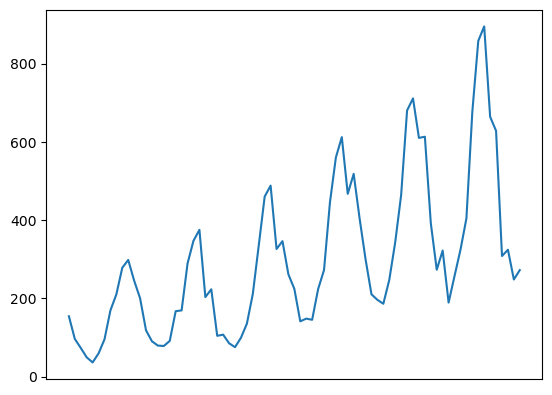

ln or diff: ln


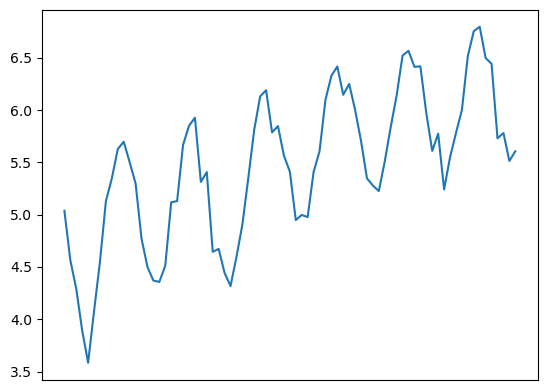

ln or diff: diff


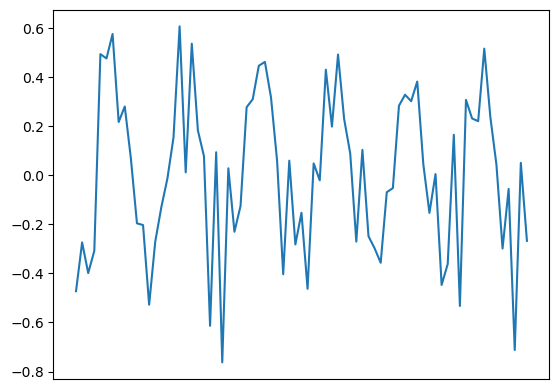

ln or diff: diff
p-value: 2.998186594945523e-10

weekly_closings_of_the_dowjones_


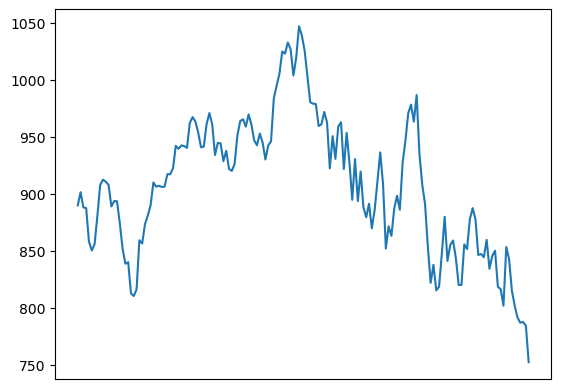

ln or diff: diff
p-value: 1.6975521393965378e-24



In [171]:
for df in my_dict:
    print(df)
    make_stationary(my_dict[df])
    print()

# 